In [1]:
import numpy as np
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q
import pandas as pd
from kalman import *

In [2]:
df = pd.read_csv('spiral_data/sensor_data_down_b.csv')
df.head()

,Accel_X,Accel_Y,Accel_Z,Magneto_X,Magneto_Y,Magneto_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Quaternion_W,Quaternion_X,Quaternion_Y,Quaternion_Z,Pressure,Temperature,Time
0,0.92,3.57,9.07,-27.1875,-23.6875,-42.5000,-5.3750,-2.5625,5.5625,0.96,3.61,9.06,0.958740,0.172546,-0.089050,-0.207642,83064.851562,23.358643,39437.0
1,1.02,3.57,9.06,-28.6875,-23.0000,-42.8750,-5.4375,-2.1250,5.3750,0.99,3.57,9.07,0.959351,0.170410,-0.089661,-0.206177,100619.148438,24.543093,39477.0
2,0.96,3.30,9.05,-28.6875,-23.0000,-42.8750,-5.8125,-1.9375,4.5000,1.00,3.54,9.08,0.959961,0.168274,-0.090210,-0.205078,100618.359375,24.563293,39517.0
3,1.19,3.46,9.00,-28.6875,-22.5625,-41.7500,-2.8125,-1.7500,2.8125,1.03,3.51,9.09,0.960266,0.167053,-0.090881,-0.204346,100617.882812,24.595760,39557.0
4,1.09,3.38,9.04,-29.3750,-23.2500,-42.1875,-3.1250,0.0000,3.4375,1.04,3.49,9.10,0.960632,0.165955,-0.090942,-0.203369,100616.453125,24.629921,39597.0


In [3]:
gyr_data = np.array([df['Gyro_X'], df['Gyro_Y'], df['Gyro_Z']]).T
acc_data = np.array([df['Accel_X'], df['Accel_Y'], df['Accel_Z']]).T
mag_data = np.array([df['Magneto_X'], df['Magneto_Y'], df['Magneto_Z']]).T
N = df.shape[0]
dt = 40

In [4]:
ekf = EKF(gyr=gyr_data, acc=acc_data, mag=mag_data)
ekf.Q.shape

(4298, 4)

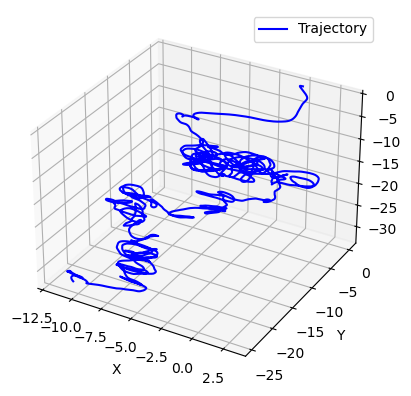

In [5]:
positions = calculate_positions(ekf.Q.shape[0], ekf.Q)
plot_predicted_positions(positions)